In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


In [2]:
from google.colab import files
files.upload()  # upload kaggle.json from your device

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emanmahmoudahmed","key":"912a0b6f5717c9aebb296dd775c51dc3"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
  0% 0.00/121M [00:00<?, ?B/s]
100% 121M/121M [00:00<00:00, 1.70GB/s]


In [5]:
!unzip -q face-expression-recognition-dataset.zip -d /content/emotion_data


In [6]:

import os

base_dir = "/content/emotion_data/images"

for dataset in ["train", "validation"]:
    dataset_path = os.path.join(base_dir, dataset)
    print(f"\n📁 {dataset.upper()} DATASET:")

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            count = len(os.listdir(folder_path))
            print(f"{folder}: {count} images")



📁 TRAIN DATASET:
neutral: 4982 images
angry: 3993 images
sad: 4938 images
surprise: 3205 images
fear: 4103 images
happy: 7164 images
disgust: 436 images

📁 VALIDATION DATASET:
neutral: 1216 images
angry: 960 images
sad: 1139 images
surprise: 797 images
fear: 1018 images
happy: 1825 images
disgust: 111 images


number of images in happy : 7164


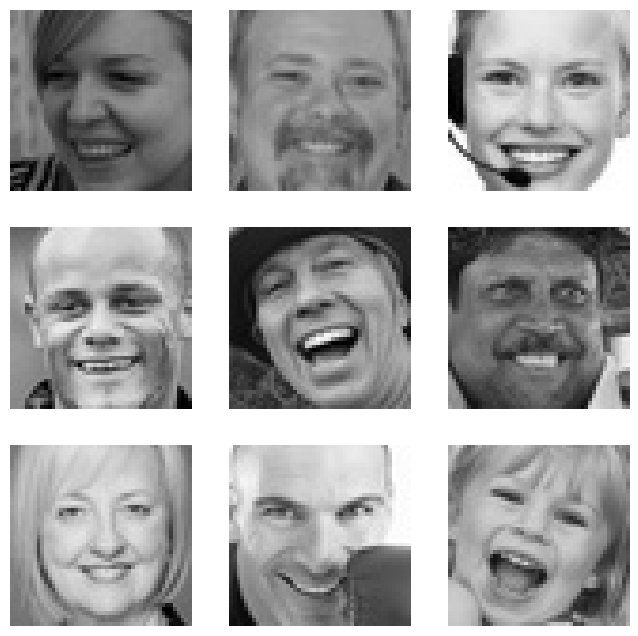

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import os

train_dir = "/content/emotion_data/images/train"
val_dir = "/content/emotion_data/images/validation"

expression = "happy"
picture_size = 48

path = os.path.join(train_dir, expression)
files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg','.jpeg','.png'))]

print("number of images in", expression, ":", len(files))
plt.figure(figsize=(8,8))
for i, f in enumerate(files[:9]):
    img = load_img(os.path.join(path, f), target_size=(picture_size, picture_size))
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ==========================
# Data Augmentation
# ==========================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen_val.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical'
)

# ==========================
# Model Definition
# ==========================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # ======================================
# # Stage 1: Freeze all layers -> train head only
# # ======================================
# for layer in base_model.layers:
#     layer.trainable = False

# ==========================
# Stage 2: Fine-Tuning — Unfreeze last 30 layers
# ==========================
for layer in base_model.layers[-30:]:
    layer.trainable = True




# Custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model for head training
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks (for both stages)
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint('best_emotion_model.keras', monitor='val_accuracy', save_best_only=True)
]

# ==========================
# Stage 1 Training — Train head only
# ==========================
history_stage1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # train head for fewer epochs first
    callbacks=callbacks
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.3778 - loss: 1.5922 - val_accuracy: 0.1393 - val_loss: 1.9726 - learning_rate: 1.0000e-04
Epoch 2/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 451s 999ms/step - accuracy: 0.5862 - loss: 1.1132 - val_accuracy: 0.5793 - val_loss: 1.1386 - learning_rate: 1.0000e-04
Epoch 3/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 448s 993ms/step - accuracy: 0.6310 - loss: 0.9913 - val_accuracy: 0.6061 - val_loss: 1.0643 - learning_rate: 1.0000e-04
Epoch 4/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 444s 985ms/step - accuracy: 0.6597 - loss: 0.9246 - val_accuracy: 0.6618 - val_loss: 0.9297 - learning_rate: 1.0000e-04
Epoch 5/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 438s 970ms/step - accuracy: 0.6842 - loss: 0.8606 - val_accuracy: 0.6520 - val_loss: 0.9612 - learning_rate: 1.0000e-04
Epoch 6/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 441s 977ms/step - accuracy: 0.7093 - loss: 0.8071 - val_accuracy: 0.6650 - val_loss: 0.9612 - learning_rate: 1.0000e-04
Epoch 7/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 

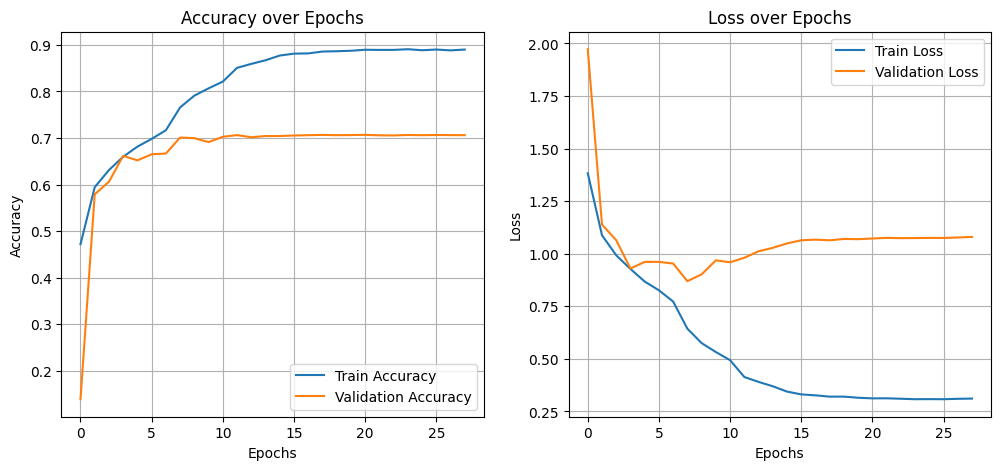

In [9]:
import matplotlib.pyplot as plt

# ============ Accuracy Plot ============
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# ============ Loss Plot ============
plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()


In [10]:
from sklearn.metrics import classification_report, confusion_matrix


# ==========================
# Step 1: Get predictions
# ==========================
# predictions = probabilities, لازم نعمل argmax لكل صورة
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# ==========================
# Step 2: True labels
# ==========================
y_true = val_generator.classes

# ==========================
# Step 3: Class names
# ==========================
class_names = list(val_generator.class_indices.keys())

# ==========================
# Step 4: Classification Report
# ==========================
report = classification_report(y_true, y_pred, target_names=class_names)
print("=== Classification Report ===")
print(report)

111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.12      0.12      0.12       960
     disgust       0.02      0.02      0.02       111
        fear       0.14      0.12      0.13      1018
       happy       0.27      0.27      0.27      1825
     neutral       0.16      0.17      0.16      1216
         sad       0.16      0.17      0.16      1139
    surprise       0.10      0.10      0.10       797

    accuracy                           0.17      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.17      0.17      0.17      7066



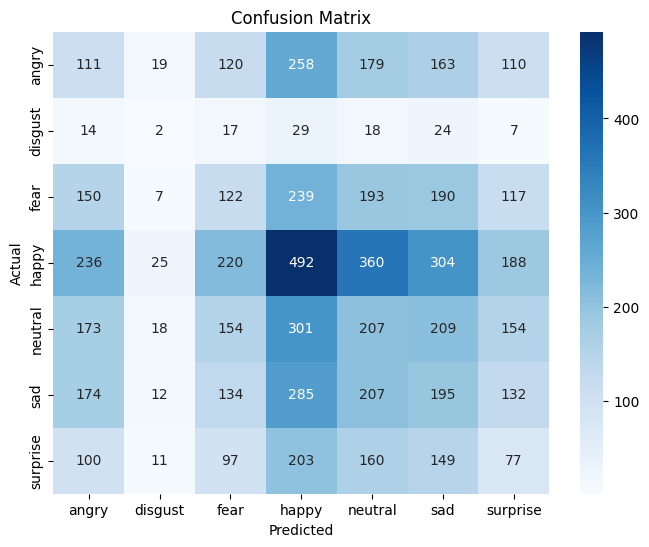

In [11]:
# ==========================
# Step 5: Confusion Matrix
# ==========================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()